In [8]:
# do required imports
import difflib
import torch
from torch.autograd import Variable
import torch.nn as nn
import pickle
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(2834)
import matplotlib.ticker as mtick
import matplotlib as matplotlib
matplotlib.rcParams.update({'font.size': 12})

In [9]:
lm = torch.load('model.pt', map_location=lambda storage, loc: storage)

In [10]:
# Load dictionary word --> id 
dictionary = pickle.load(open('dict', 'rb'))

# set the maximum sequence length
max_seq_len = 50

# function to transform sentence into word id's and put them in a pytorch Variable
# NB Assumes the sentence is already tokenised!
def tokenise(sentence, dictionary):
    words = sentence.split(' ')
    l = len(words)
    assert l <= max_seq_len, "sentence too long"
    token = 0
    ids = torch.LongTensor(l)

    for word in words:
        try:
            ids[token] = dictionary.word2idx[word]
        except KeyError:
            print( word)
            raw_input()
            ids[token] = dictionary.word2idx['<unk>']
        token += 1
    return ids

In [11]:
# load pytorch softmax function
softmax = nn.Softmax()

def evaluate(model, dictionary, sentence, check_words):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    
    # number of tokens (= output size)
    ntokens = len(dictionary)
    hidden = model.init_hidden(1)
    
    # tokenise the sentence, put in torch Variable
    test_data = tokenise(sentence, dictionary)
    input_data = Variable(test_data, volatile=True)

    # run the model, compute probabilities by applying softmax
    output, hidden = model(input_data, hidden)
    output_flat = output.view(-1, ntokens)
    logits = output[-1, :]
    sm = softmax(logits).view(ntokens)
    
    # get probabilities of certain words by looking up their
    # indices and print them
    def get_prob(word):
        return sm[dictionary.word2idx[word]].data[0]

    #print (sentence, '\n')
    #print ('\n'.join(
    #        ['%s: %f' % (word, get_prob(word)) for word in check_words]
    #        ) )
    return  [{word : get_prob(word)} for word in check_words]

In [12]:
# Compose sentence prefixes with frequent words.
# The sentence prefixes are intended to test intervening nouns.


NN = ['company', 'year', 'market', 'share', 'stock', 'system', 'president', 'business', 
      'quarter', 'government', 'time', 'week', 'price', 'group', 'interest',
      'industry', 'unit','month', 'rate', 'investment', 'state', 'producer', 'income', 
      'program', 'bank', 'part', 'plan', 'sale', 'issue', 'tax', 'way', 'loss', 'executive', 'day', 'bid', 'data', 'line','hour', 'plant', 'concern']

NNS = ['companies', 'years', 'markets', 'shares', 'stocks', 'systems', 'presidents', 
       'businesses', 'quarters', 'governments', 'times', 'weeks', 'prices', 'groups', 'interests', 'industries', 
       'units', 'months', 'rates', 'investments', 'states', 'producers', 'incomes', 'programs', 'banks', 'parts', 'plans', 
      'sales', 'issues', 'taxes', 'ways', 'losses', 'executives', 'days', 'bids', 'data', 'lines', 'hours', 'plants', 'concerns',]

VBP = ['are', 'have', 'do', 'say', 'think', 'want', 'expect', 'include', 'ask', 
       'make', 'need', 'know', 'see', 'get', 'seem', 'remain', 'continue', 'show', 'buy', 
       'feel', 'go', 'sell', 'take', 'use', 'plan', 'look', 'tend', 'hope', 'argue', 'give',
       'pay', 'appear', 'suggest', 'fear', 'find', 'come', 'offer', 'contend', 'agree', 'provide']

VBZ = ['is', 'has', 'does', 'says', 'thinks', 'wants', 'expects', 'includes', 'asks', 'makes',
      'needs', 'knows', 'sees', 'gets', 'seems', 'remains', 'continues', 'shows', 'buys', 'feels', 'goes', 'sells',
      'takes', 'uses', 'plans', 'looks', 'tends', 'hopes', 'argues', 'gives', 'pays', 'appears', 'suggests', 'fears',
      'finds', 'comes', 'offers', 'contends', 'agrees', 'provides']

attractor_helpers = ['in the', 'by the', 'close to the', 'of the', 'at the', 'and not the', 'without']



In [14]:
def calculate_error_rate(sentences):
    result = calculate_errors(sentences)
    #print(result)
    return 1- sum(result)/len(result)
    
def calculate_errors(sentences):
    return [1 if is_correct_prediction(s[0], s[1], s[2]) else 0 for s in sentences]

def is_correct_prediction(sentence, check_words, correct_word):
    predictions = evaluate(lm, dictionary, sentence, check_words)
    words,preds = zip(*list(map(lambda x: list(x.items())[0],predictions)))
    predicted_word = words[np.argmax(preds)]
    return predicted_word == correct_word

In [15]:
# Compose sentence prefixes with frequent words with one and without attractors

def gen_no_attractors(num_sentences, num_words, NN, NNS, VBP, VBZ):
    assert(len(NN) == len(NNS) == len(VBP) == len(VBZ))
    sentences_si = []
    sentences_pl =[]
    indices_x = []
    indices_u = []
    for i in range(num_sentences):
        while True:
            x,y = np.random.randint(num_words, size=2)
            if (x,y) not in indices_x:
                indices_x.append((x,y))
                break
        while True:
            u,v = np.random.randint(num_words, size=2)
            if (u,v) not in indices_u:
                indices_u.append((u,v))
                break
        sentences_si.append((f"the {NN[x]}", [VBP[y], VBZ[y]], VBZ[y],))
        sentences_pl.append((f"the {NNS[u]}", [VBP[v], VBZ[v]], VBP[v],))
    return sentences_si, sentences_pl

def gen_one_attractor(num_sentences, num_words, same, NN, NNS, VBP, VBZ, 
                      template = "the {} of the {}", first_dep = True):

    assert(len(NN) == len(NNS) == len(VBP) == len(VBZ))
    sentences_si = []
    sentences_pl =[]
    indices = []
    for i in range(num_sentences):
        while True:
            x,y,z = np.random.randint(num_words, size=3)
            if (x,y,z) not in indices:
                indices.append((x,y,z))
                break
        if(same):
            sentences_si.append((template.format(NN[x], NN[z]), [VBP[y], VBZ[y]], VBZ[y],))
            sentences_pl.append((template.format(NNS[x], NNS[z]), [VBP[y], VBZ[y]], VBP[y],))
        elif first_dep:
            sentences_si.append((template.format(NN[x], NNS[z]), [VBP[y], VBZ[y]], VBZ[y],))
            sentences_pl.append((template.format(NNS[x], NN[z]), [VBP[y], VBZ[y]], VBP[y],))
        else:
            sentences_si.append((template.format(NNS[x], NN[z]), [VBP[y], VBZ[y]], VBZ[y],))
            sentences_pl.append((template.format(NN[x], NNS[z]), [VBP[y], VBZ[y]], VBP[y],))
    return sentences_si, sentences_pl

num_sentences = 1000
num_words = len(NN)



In [16]:
# These seed lines make sure that all test variations run on a testset
# containing sentences that are composed from the same 'noun'-'verb' combinations.
# This has two advantages:
# 1) The error rates are more comparable
# 2) The outputs can be compared on a one-by-one basis, i.e.
# The <keys> that the <cabinet> ...[contain, contains]: 0, 
# The <keys>      the <cabinet> ...[contain, contains]: 1, 

np.random.seed(100)

#compare different templates
#calculate_errors(one_attractor_si_same[0:100])
one_attractor_si_diff_possesive, one_attractor_pl_diff_possesive = gen_one_attractor(
    num_sentences, num_words,False, NN, NNS, VBP, VBZ, template = "the {} of the {}", first_dep = True)


np.random.seed(100)

#compare different templates
#calculate_errors(one_attractor_si_same[0:100])
one_attractor_si_diff_relativizer, one_attractor_pl_diff_relativizer = gen_one_attractor(
    num_sentences, num_words,False, NN, NNS, VBP, VBZ, template = "the {} that the {}", first_dep = False)

np.random.seed(100)

one_attractor_si_diff_no_relativizer, one_attractor_pl_diff_no_relativizer = gen_one_attractor(
    num_sentences, num_words,False, NN, NNS, VBP, VBZ, "the {} the {}", first_dep = False)

print("Error rates different categories: ")

error_rate_one_attractor_si_diff_possesive = calculate_error_rate(one_attractor_si_diff_possesive[0:100])
print ("%.2f" % error_rate_one_attractor_si_diff_possesive , f"example: {one_attractor_si_diff_possesive[0]}")

error_rate_one_attractor_pl_diff_possesive = calculate_error_rate(one_attractor_pl_diff_possesive[0:100])
print ("%.2f" % error_rate_one_attractor_pl_diff_possesive , f"example: {one_attractor_pl_diff_possesive[0]}")

error_rate_one_attractor_si_diff_relativizer = calculate_error_rate(one_attractor_si_diff_relativizer[0:100])
print ("%.2f" % error_rate_one_attractor_si_diff_relativizer , f"example: {one_attractor_si_diff_relativizer[0]}")

error_rate_one_attractor_pl_diff_relativizer = calculate_error_rate(one_attractor_pl_diff_relativizer[0:100])
print ("%.2f" % error_rate_one_attractor_pl_diff_relativizer , f"example: {one_attractor_pl_diff_relativizer[0]}")

error_rate_one_attractor_si_diff_no_relativizer = calculate_error_rate(one_attractor_si_diff_no_relativizer[0:100])
print ("%.2f" % error_rate_one_attractor_si_diff_no_relativizer , f"example: {one_attractor_si_diff_no_relativizer[0]}")

error_rate_one_attractor_pl_diff_no_relativizer = calculate_error_rate(one_attractor_pl_diff_no_relativizer[0:100])
print ("%.2f" % error_rate_one_attractor_pl_diff_no_relativizer , f"example: {one_attractor_pl_diff_no_relativizer[0]}")

Error rates different categories: 
0.62 example: ('the quarter of the shares', ['plan', 'plans'], 'plans')
0.65 example: ('the quarters of the share', ['plan', 'plans'], 'plan')
0.20 example: ('the quarters that the share', ['plan', 'plans'], 'plans')
0.29 example: ('the quarter that the shares', ['plan', 'plans'], 'plan')
0.17 example: ('the quarters the share', ['plan', 'plans'], 'plans')
0.27 example: ('the quarter the shares', ['plan', 'plans'], 'plan')


In [ ]:
no_attractors_si_least

In [24]:
templates = [
    "the {} of the {}",
    "the {} in the {}",
    "the {} the {}",
    "the {} that the {}"
#    "the {} , that the {}"
]

In [26]:
num_sentences = 100

results = {}
for t in templates:
    np.random.seed(100) #generate from same verbs and nouns for each template
    print (t)
    si, pl = gen_one_attractor(
        num_sentences, 
        num_words, 
        False, 
        NN, 
        NNS, 
        VBP, 
        VBZ, 
        template = t, 
        first_dep = True)
    si_most_recent_noun_rate = calculate_error_rate(si)
    pl_most_recent_noun_rate = calculate_error_rate(pl)
    most_recent_noun_rate = 0.5*(pl_most_recent_noun_rate + si_most_recent_noun_rate)
    results[t] = most_recent_noun_rate


print (results)

the {} of the {}
the {} in the {}
the {} the {}
the {} that the {}
{'the {} of the {}': 0.635, 'the {} in the {}': 0.595, 'the {} the {}': 0.78, 'the {} that the {}': 0.755}


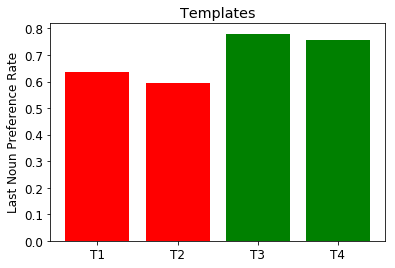

In [42]:
template_names = [f"T{i + 1}" for i in range(0, len(templates))]
last_noun_rates = results.values()
y_pos = np.arange(len(templates))
plt.bar(y_pos, last_noun_rates, align='center', color=['r', 'r', 'g', 'g'])
plt.xticks(y_pos, template_names)
plt.ylabel('Last Noun Preference Rate')
plt.title('Templates')
 
plt.show()

In [31]:
template = "the {} and the {}"

si, pl = gen_one_attractor(
    num_sentences, 
    num_words, 
    True, 
    NN, 
    NNS, 
    VBP, 
    VBZ, 
    template = template)

si_error_rate = 1 - calculate_error_rate(si) #error means plural prediction which is actually good 
pl_error_rate = calculate_error_rate(pl)


In [32]:
si_error_rate

0.73

In [33]:
pl_error_rate

0.13

In [34]:
si[0:10]

[('the loss and the plan', ['take', 'takes'], 'takes'),
 ('the issue and the tax', ['show', 'shows'], 'shows'),
 ('the week and the part', ['agree', 'agrees'], 'agrees'),
 ('the data and the rate', ['have', 'has'], 'has'),
 ('the plan and the loss', ['include', 'includes'], 'includes'),
 ('the price and the data', ['take', 'takes'], 'takes'),
 ('the state and the market', ['seem', 'seems'], 'seems'),
 ('the program and the executive', ['sell', 'sells'], 'sells'),
 ('the unit and the interest', ['are', 'is'], 'is'),
 ('the month and the stock', ['show', 'shows'], 'shows')]